https://zhuanlan.zhihu.com/p/261701780

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # mpimg 用于读取图片
import pandas as pd 
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as Data 
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import STL10
# import hiddenlayer as hl
from tqdm import tqdm
import random
import os
from PIL import Image


%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '3,0'
torch.backends.cudnn.benchmark = True

In [3]:
# 首先，从上述链接中下载完STL10的数据集后，开始对数据做预处理。STL10中都是96*96的RGB图片，训练集放在了train_X.bin的文件中，可以用做自编码器的无监督学习，下面是第数据的预处理：
def read_image(data_path):
    with open(data_path, "rb") as f:
        data1 = np.fromfile(f, dtype=np.uint8)
        # 塑形成[batch, c, h, w]
        images = np.reshape(data1, [-1, 3, 96, 96])
        # 图像转化为RGB(即最后一个维度是通道维度)的形式，方便使用matplotlib进行可视化
        images = np.transpose(images, [0, 3, 2, 1])
    return images / 255
data_path = "../data/stl10_binary/train_X.bin"
images = read_image(data_path)
images.shape

(5000, 96, 96, 3)

In [4]:
# 下面定义一个函数，为干净的图片添加高斯噪音，这部分添加了噪音的数据，将成为自编码器的输入。其中的random_noise是属于skimage.util下的一个方法。

def gaussian_noise(images, sigma):
    """sigma: 噪声标准差"""
    sigma2 = sigma**2 / (255 ** 2)   # 噪声方差
    images_noisy = np.zeros_like(images)
    for ii in range(images.shape[0]):
        image = images[ii]
        # 使用skimage中的函数增加噪音
        noise_im = random_noise(image, mode="gaussian", var=sigma2, clip=True)
        images_noisy[ii] = noise_im
    return images_noisy
def gaussian_gamma(images, sigma):
    """sigma: 噪声标准差, gamma: gamma矫正"""
    sigma2 = sigma**2 / (255 ** 2)   # 噪声方差
    res = np.zeros_like(images)
    for ii in tqdm(range(images.shape[0])):
        image = images[ii]
        # 使用skimage中的函数增加噪音,gamma,在1.5-4.5之间
        gamma = random.uniform(2.5,3)
        noise_im = random_noise(image, mode="gaussian", var=sigma2, clip=True)
        # 使用gamma来让图像变暗
        gamma_noise_im = np.power(noise_im, gamma)

        res[ii] = gamma_noise_im
    return res

images_noise = gaussian_gamma(images, 25,)
print("image_noise:", images_noise.min(), "~", images_noise.max())

100%|██████████| 5000/5000 [00:15<00:00, 332.27it/s]


image_noise: 0.0 ~ 1.0


In [5]:
#将这些图片保存下来，
# for ii in tqdm(np.arange(5000)):
#   im_gt = Image.fromarray(np.uint8(images[ii, ...]*255))
#   im_gt = im_gt.resize((256,256))
#   im_gt.save("../datasets/stl10/groundtruth/"+str(ii)+".png")

#   im_input = Image.fromarray(np.uint8(images_noise[ii, ...]*255))
#   im_input = im_input.resize((256,256))
#   im_input.save("../datasets/stl10/input/"+str(ii)+".png")

  


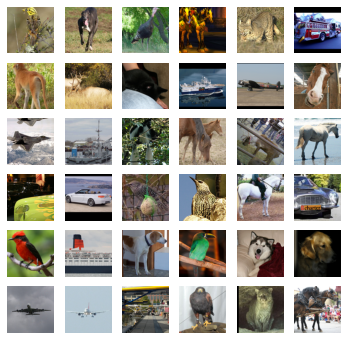

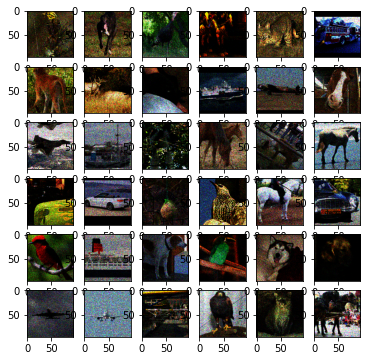

In [6]:
# 下面可视化一些添加了噪音后的图片，其中iamges[ii, ...]中的...是numpy库中的语法糖，作用等价于若干个:,:,:的组合，也就是数组剩余的每个维度都全取。
plt.figure(figsize=[6, 6])
for ii in np.arange(36):
    plt.subplot(6, 6, ii + 1)
    plt.imshow(images[ii, ...])
    plt.axis("off")
plt.show()

# 带噪音的图片
plt.figure(figsize=[6, 6])
for ii in np.arange(36):
    plt.subplot(6, 6, ii + 1)
    plt.imshow(images_noise[ii, ...])
plt.show()


In [7]:
# 数据与处理完后，老规矩，构建loader，以便于训练时直接拿出一个batch的数据出来训练。
# 首先将数据集切分为训练集和验证集，并转换为torch张量。

# 数据集准备为PyTorch可用的形式，转化为[样本, 通道, 高, 宽]
data_X = np.transpose(images_noise, (0, 3, 2, 1))
data_Y = np.transpose(images, (0, 3, 2, 1))

X_train, X_val, y_train, y_val = train_test_split(data_X, data_Y, 
                                                  test_size=0.2, random_state=123)
# 转化为torch张量
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
# 将X与y整合在一起
train_data = Data.TensorDataset(X_train, y_train)
val_data = Data.TensorDataset(X_val, y_val)

print("X_train.shape", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)

X_train.shape torch.Size([4000, 3, 96, 96])
y_train.shape: torch.Size([4000, 3, 96, 96])
X_val.shape: torch.Size([1000, 3, 96, 96])
y_val.shape: torch.Size([1000, 3, 96, 96])


In [8]:
#数据加载器
train_loader = Data.DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = Data.DataLoader(
    dataset=val_data,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

In [9]:
# 构建网络
# 接下来定义一个DenoiseAutoEncoder类，其中包括了自编码器的encoder和decoder，forward返回原数据编码后的特征映射和特征映射解码后的重构图像。
class DenoiseAutoEncoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoEncoder, self).__init__()
        # Encoder
        self.Encoder = nn.Sequential(
            # param [input_c, output_c, kernel_size, stride, padding]
            nn.Conv2d(3, 64, 3, 1, 1),   # [, 64, 96, 96]
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, 1, 1), # [, 64, 96, 96]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             # [, 64, 48, 48]
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, 1, 1),  # [, 64, 48, 48]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, 1, 1), # [, 128, 48, 48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, 1, 1), # [, 128, 48, 48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, 1, 1), # [, 256, 48, 48]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                 # [, 256, 24, 24]
            nn.BatchNorm2d(256)   
        )
        
        # decoder
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3 ,1, 1),   # [, 128, 24, 24]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 128, 3, 2, 1, 1),   # [, 128, 48, 48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),    # [, 64, 48, 48]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, 1, 1),      # [, 32, 48, 48]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, 1, 1),      # [, 32, 48, 48]
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1),  # [, 16, 96, 96]
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, 3, 1, 1),         # [, 3, 96, 96]
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return encoder, decoder
        
# 输出网络结构
DAEmodel = DenoiseAutoEncoder().to(device)



In [10]:
# from torchviz import make_dot
# x = torch.randn(1, 3, 96, 96).requires_grad_(True)  # 模拟输入
# _, y = DAEmodel(x)

# vis_net = make_dot(y, params=dict(list(DAEmodel.named_parameters()) + [("x", x)]))
# vis_net.view()

In [11]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
class SSIM_Loss(SSIM):
    def forward(self, img1, img2):
        return 100*( 1 - super(SSIM_Loss, self).forward(img1, img2) )
criterion = SSIM_Loss(data_range=1.0, size_average=True, channel=3)

In [12]:
# 有了网络和数据加载器后，可以开始训练了，其中，我们使用hiddenlayer库来做训练过程动态可视化：
LR = 0.0002
epoch_num = 10
optimizer = optim.Adam(DAEmodel.parameters(), lr=LR)
# loss_func = nn.MSELoss()

# history = hl.History()
# canvas = hl.Canvas()

train_num, val_num = 0, 0

for epoch in range(epoch_num):
    train_loss_epoch, val_loss_epoch = 0, 0
    
    # 训练
    for step, (b_x, b_y) in enumerate(train_loader):
        DAEmodel.train()
        
        _, output = DAEmodel(b_x)
        loss = criterion(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * b_x.size(0)
        train_num += b_x.size(0)
    
    # 验证
    for step, (b_x, b_y) in enumerate(val_loader):
        DAEmodel.eval()
        _, output = DAEmodel(b_x)
        loss = criterion(output, b_y)
        val_loss_epoch += loss.item() * b_x.size(0)
        val_num += b_x.size(0)
    
    # 计算一个epoch的损失
    train_loss = train_loss_epoch / train_num
    val_loss = val_loss_epoch / val_num
    print('epoch',epoch+1,'loss',train_loss,val_loss)
    train_num, val_num = 0, 0
    
    # 记录hiddenlayer的记录并动态可视化训练过程
    # history.log(epoch, train_loss = train_loss, val_loss = val_loss)
    # with canvas:
    #     canvas.draw_plot([
    #         history["train_loss"],
    #         history["val_loss"]
    #     ])
    #保存模型
    # torch.save(DAEmodel.state_dict(), "autodecode.mdl")



epoch 1 loss 45.20793205261231 32.80437170410156
epoch 2 loss 28.619363327026367 26.12824053955078
epoch 3 loss 26.04602508544922 25.701722152709962
epoch 4 loss 24.412458892822265 25.444526885986328
epoch 5 loss 23.50705905151367 25.351147033691408
epoch 6 loss 22.593982666015624 22.032756927490233
epoch 7 loss 21.901675979614257 21.58733558654785
epoch 8 loss 21.14549206542969 21.30366716003418
epoch 9 loss 20.421433944702148 21.554526336669923
epoch 10 loss 19.9412635345459 20.24546369934082


In [13]:
# 网络训练完后，我们可以随便挑一张图片来测试一下去噪的效果如何，此处我们使用PSNR（峰值信噪比）来度量干净的原图和自编码器输出的去噪图之间的相似性，PSNR越大说明两个图片之间越相似。
imageindex = 1
im = X_val[imageindex, ...]
im = im.unsqueeze(0)
im_noise = np.transpose(im.cpu().data.numpy(), (0, 3, 2, 1))
im_noise = im_noise[0, ...]
# 去噪
DAEmodel.eval()
_, output = DAEmodel(im)
im_denoise= np.transpose(output.cpu().data.numpy(), (0, 3, 2, 1))
im_denoise = im_denoise[0, ...]
# 输出
im = y_val[imageindex, ...]
im_origin = im.unsqueeze(0)
im_origin = np.transpose(im_origin.cpu().data.numpy(), (0, 3, 2, 1))
im_origin = im_origin[0, ...]

# 计算去噪后的PSNR
print("加躁后的PSNR:", peak_signal_noise_ratio(im_origin, im_noise))
print("去噪后的PSNR:", peak_signal_noise_ratio(im_origin, im_denoise))


加躁后的PSNR: 12.664086955422754
去噪后的PSNR: 22.263820545309493


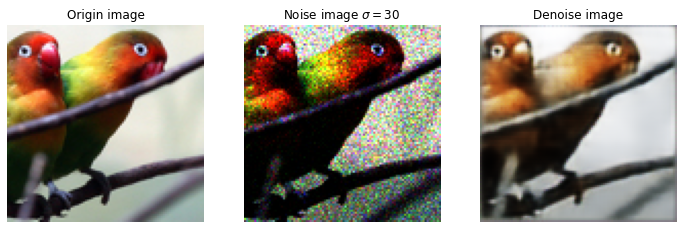

In [14]:
# 将图片可视化
plt.figure(figsize=[12, 4])
plt.subplot(1, 3, 1)
plt.imshow(im_origin)
plt.axis("off")
plt.title("Origin image")

plt.subplot(1, 3, 2)
plt.imshow(im_noise)
plt.axis("off")
plt.title("Noise image $\sigma=30$")

plt.subplot(1, 3, 3)
plt.imshow(im_denoise)
plt.axis("off")
plt.title("Denoise image")

plt.show()

In [15]:
# 接下来，我们试着在整个验证集上计算模型的得到的去噪图片与带噪图片相比，PSNR的平均提升量：

PSNR_val = []
DAEmodel.eval()
for ii in range(X_val.shape[0]):
    imageindex = ii
    # 输入
    im = X_val[imageindex, ...]
    im = im.unsqueeze(0)
    im_noise = np.transpose(im.cpu().data.numpy(), (0, 3, 2, 1))
    im_noise = im_noise[0, ...]
    # 去噪
    _, output = DAEmodel(im)
    im_denoise = np.transpose(output.cpu().data.numpy(), (0, 3, 2, 1))
    im_denoise = im_denoise[0, ...]
    # 输出
    im = y_val[imageindex, ...] 
    im_origin = im.unsqueeze(0)
    im_origin = np.transpose(im_origin.cpu().data.numpy(), (0, 3, 2, 1))
    im_origin = im_origin[0, ...]
    
    PSNR_val.append(peak_signal_noise_ratio(im_origin, im_denoise) - peak_signal_noise_ratio(im_origin, im_noise))
    
print("PSNR的平均提升量：", np.mean(PSNR_val), "dB")


PSNR的平均提升量： 10.792801831630328 dB


In [16]:
# 取一张lol图片，看效果
# high = mpimg.imread('data/lol485/high/2.png') # 
# low = mpimg.imread('data/lol485/low/2.png') # 

DAEmodel = DenoiseAutoEncoder().to(device)
checkpoint = torch.load("autodecode.mdl")
DAEmodel.load_state_dict(checkpoint)


DAEmodel.eval()
source_input_path = '../datasets/ain1/input'
for file in tqdm(os.listdir(source_input_path)):
    file_path = os.path.join(source_input_path, file)
    low = mpimg.imread(file_path) # 
    input = np.transpose(low, (2, 1, 0))
    input = torch.tensor(input, dtype=torch.float32).to(device)
    input = input.unsqueeze(0)
    _, output = DAEmodel(input)
    im_enhance= np.transpose(output.cpu().data.numpy(), (0, 3, 2, 1))
    im_enhance = im_enhance[0, ...]

    plt.figure(figsize=[20, 20])
    plt.subplot(1, 2, 1)
    plt.imshow(low)
    plt.axis("off")
    plt.title("Lowlight image")

    plt.subplot(1, 2, 2)
    plt.imshow(im_enhance)
    plt.axis("off")
    plt.title("LowlightEnhance image")


# input = np.transpose(low, (2, 1, 0))
# input = torch.tensor(input, dtype=torch.float32).to(device)
# input = input.unsqueeze(0)
# im_enhance= np.transpose(output.cpu().data.numpy(), (0, 3, 2, 1))
# im_enhance = im_enhance[0, ...]

# plt.figure(figsize=[20, 20])
# plt.subplot(1, 3, 1)
# plt.imshow(low)
# plt.axis("off")
# plt.title("Lowlight image")

# plt.subplot(1, 3, 2)
# plt.imshow(im_enhance)
# plt.axis("off")
# plt.title("LowlightEnhance image")

# plt.subplot(1, 3, 3)
# plt.imshow(high)
# plt.axis("off")
# plt.title("Ground truth")
# print("原始的PSNR:", peak_signal_noise_ratio(low, high))
# print("暗光增强后的PSNR:", peak_signal_noise_ratio(im_enhance, high))

  0%|          | 0/18 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 408.00 MiB (GPU 0; 10.76 GiB total capacity; 1.82 GiB already allocated; 179.12 MiB free; 3.52 GiB reserved in total by PyTorch)

In [ ]:
#在loldataset上计算平均psnr

#获取lol485目录信息

lolList = os.listdir('./data/lol15/high')
DAEmodel.eval()
PSNR_init = []
PSNR_enhance = []
PSNR_plus = []
for imgName in lolList:
    high = mpimg.imread('data/lol15/high/'+imgName) # 
    low = mpimg.imread('data/lol15/low/'+imgName) # 
    input = np.transpose(low, (2, 1, 0))
    input = torch.tensor(input, dtype=torch.float32).to(device)
    input = input.unsqueeze(0)
    _, output = DAEmodel(input)
    im_enhance= np.transpose(output.cpu().data.numpy(), (0, 3, 2, 1))
    im_enhance = im_enhance[0, ...]
    PSNR_init.append(peak_signal_noise_ratio(low, high))
    PSNR_enhance.append(peak_signal_noise_ratio(im_enhance, high))
    PSNR_plus.append(peak_signal_noise_ratio(im_enhance, high)-peak_signal_noise_ratio(low, high))
    # print("原始的PSNR:", peak_signal_noise_ratio(low, high))
    # print("暗光增强后的PSNR:", peak_signal_noise_ratio(im_enhance, high))
print(np.mean(PSNR_init))
print(np.mean(PSNR_enhance))
print(np.mean(PSNR_plus))

# PSNR_val = []
# DAEmodel.eval()
# for ii in range(X_val.shape[0]):
#     imageindex = ii
#     # 输入
#     im = X_val[imageindex, ...]
#     im = im.unsqueeze(0)
#     im_noise = np.transpose(im.cpu().data.numpy(), (0, 3, 2, 1))
#     im_noise = im_noise[0, ...]
#     # 去噪
#     _, output = DAEmodel(im)
#     im_denoise = np.transpose(output.cpu().data.numpy(), (0, 3, 2, 1))
#     im_denoise = im_denoise[0, ...]
#     # 输出
#     im = y_val[imageindex, ...] 
#     im_origin = im.unsqueeze(0)
#     im_origin = np.transpose(im_origin.cpu().data.numpy(), (0, 3, 2, 1))
#     im_origin = im_origin[0, ...]
    
#     PSNR_val.append(peak_signal_noise_ratio(im_origin, im_denoise) - peak_signal_noise_ratio(im_origin, im_noise))
    
# print("PSNR的平均提升量：", np.mean(PSNR_val), "dB")